In [1]:
"""Backend supported: pytorch, paddle, jax

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""
import deepxde as dde
import numpy as np


SPINN = True
if SPINN:
    dde.config.set_default_autodiff("forward")

lmbd = 1.0
mu = 0.5
Q = 4.0

# Trainable parameters
lmbd_trainable = dde.Variable(lmbd - 0.2)
mu_trainable = dde.Variable(mu - 0.2)


sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack
pi = dde.backend.as_tensor(np.pi)

if dde.backend.backend_name == "jax":
    import jax.numpy as jnp

geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Exact solutions
def func(x):
    if SPINN:
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:,0],x[:,1], indexing='ij')]
        x = stack(x_mesh, axis=-1)

    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))


def fx(x):
    return (
        -lmbd
        * (
            4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - mu
        * (
            np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
    )


def fy(x):
    return (
        lmbd
        * (
            3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
            - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
        )
        - mu
        * (
            2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
            + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4
        )
        + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
    )

def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[0] # second element is the function used by jax to compute the gradients
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)

def pde(x, f):
    # x_mesh = jnp.meshgrid(x[:,0].ravel(), x[:,0].ravel(), indexing='ij')
    if SPINN:
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:,0],x[:,1], indexing='ij')]
        x = stack(x_mesh, axis=1)

    E_xx = jacobian(f, x, i=0, j=0)
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu_trainable + lmbd_trainable) + E_yy * lmbd_trainable
    S_yy = E_yy * (2 * mu_trainable + lmbd_trainable) + E_xx * lmbd_trainable
    S_xy = E_xy * 2 * mu_trainable

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y - fx(x)
    momentum_y = Sxy_x + Syy_y - fy(x)

    if dde.backend.backend_name == "jax":
        f = f[0] # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]


def hardBC(x,f):
    if SPINN:
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:,0],x[:,1], indexing='ij')]
        x = stack(x_mesh, axis=-1)

    Ux = f[:,0]*x[:,1]*(1-x[:,1])
    Uy = f[:,1]*x[:,0]*(1-x[:,0])*x[:,1]

    Sxx = f[:,2]*x[:,0]*(1-x[:,0])
    Syy = f[:,3]*(1-x[:,1]) + (lmbd + 2*mu)*Q*sin(pi*x[:,0])
    Sxy = f[:,4] 
    return stack((Ux,Uy,Sxx,Syy,Sxy),axis=1).squeeze()

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Set the default automatic differentiation to forward mode.


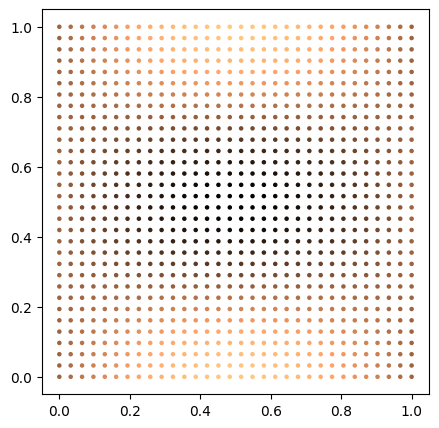

In [2]:
import matplotlib.pyplot as plt


# X_DIC = geom.uniform_points(1000, boundary=False)
X_DIC_input = np.stack([np.linspace(0, 1, 32)] * 2, axis=1)
X_DIC_mesh = [x_.ravel() for x_ in np.meshgrid(X_DIC_input[:,0],X_DIC_input[:,1])]
X_DIC_plot = stack(X_DIC_mesh, axis=-1)
U_DIC = func(X_DIC_input)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_DIC_plot[:, 0], X_DIC_plot[:, 1], s=5, c=U_DIC[:, 0], cmap="copper")

measure_Ux = dde.PointSetBC(X_DIC_input, U_DIC[:, 0:1], component=0)
measure_Uy = dde.PointSetBC(X_DIC_input, U_DIC[:, 1:2], component=1)

# measure_Ux = dde.PointSetOperatorBC(X_DIC_input, U_DIC[:, 0:1], lambda inputs,outputs,X: outputs[:,0:1])
# measure_Uy = dde.PointSetOperatorBC(X_DIC_input, U_DIC[:, 1:2], lambda inputs,outputs,X: outputs[:,1:2])

bcs = [measure_Ux, measure_Uy]

In [3]:
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=36**2,
    num_boundary=0,
    solution=func,
    num_test=36**2,
)

activation = "tanh"
initializer = "Glorot uniform"
if SPINN:
    layers = [32, 32, 32, 32, 5]
    net = dde.nn.SPINN(layers, activation, initializer)
else:
    layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
    net = dde.nn.PFNN(layers, activation, initializer)

net.apply_output_transform(hardBC)

model = dde.Model(data, net)

In [4]:
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=1000, display_every=100)

Compiling model...
'compile' took 1.757018 s

Training model...



: 

In [ ]:
if SPINN:
    dde.save_loss_history(losshistory, r"results/losshistory_SPINN.dat")
    dde.save_trainstate(train_state, r"results/trainstate_SPINN.dat")
else:
    dde.save_loss_history(losshistory, r"results/losshistory_PFNN.dat")
    # dde.save_trainstate(train_state, r"results/trainstate_PFNN.dat")
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)